In [1]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from datasets import load_dataset
from sklearn.metrics import classification_report
import torch

In [2]:
# Load the pre-trained model and tokenizer
model_name = "./finetuned_wikineural"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

In [1]:
# Load preprocessed French dataset
from datasets import load_from_disk
german_dataset = load_from_disk("Data_de/test_de")

In [2]:
print(german_dataset[0])  # Print the first example
print(german_dataset.features)  # Print the dataset features


{'tokens': ['WEITERLEITUNG', 'Hu', 'Xian'], 'ner_tags': [0, 5, 6, 6, 6], 'langs': ['de', 'de', 'de', 'de', 'de'], 'spans': ['LOC: Hu ( Xi’an )'], 'input_ids': [101, 160, 11259, 37611, 24093, 51036, 37611, 69849, 11447, 43707, 59876, 10206, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, 0, -100, -100, -100, -100, -100, -100, -100, 5, 6, -100, -100]}
{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None), 'langs': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'spans': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention

In [4]:
from collections import Counter

# Extrahiere die ner_tags aus dem Dataset
ner_tags = [tag for example in german_dataset for tag in example["ner_tags"]]

# Mapping der numerischen Tags zu den Entity-Namen
tag_map = {
    0: "O",        # Outside any entity
    1: "B-PER",    # Beginning of a Person entity
    2: "I-PER",    # Inside a Person entity
    3: "B-ORG",    # Beginning of an Organization entity
    4: "I-ORG",    # Inside an Organization entity
    5: "B-LOC",    # Beginning of a Location entity
    6: "I-LOC"     # Inside a Location entity
}

# Konvertiere numerische Tags in lesbare Labels
ner_labels = [tag_map[tag] for tag in ner_tags]

# Zähle die Häufigkeiten der verschiedenen Tags
entity_counts = Counter(ner_labels)

In [5]:
# Relevante Entitäten filtern
filtered_counts = {
    entity: count for entity, count in entity_counts.items() if entity in ["B-PER", "B-ORG", "B-LOC"]
}

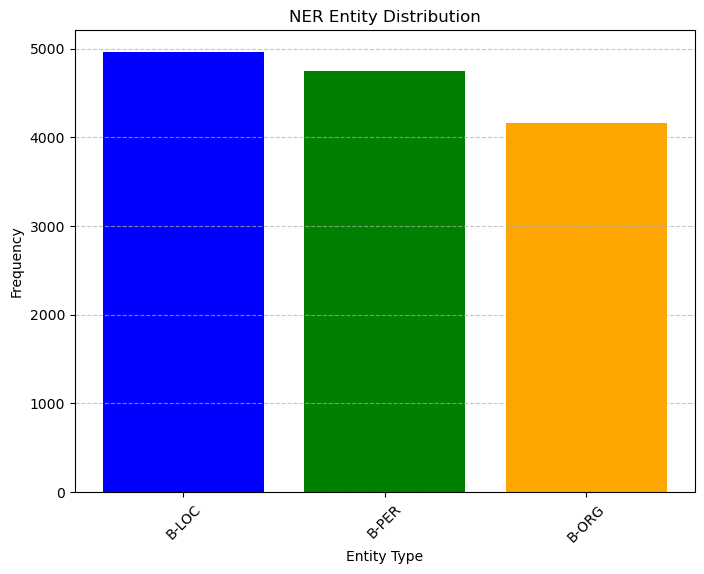

In [6]:
import matplotlib.pyplot as plt

# Daten für das Diagramm vorbereiten
entities = list(filtered_counts.keys())
counts = list(filtered_counts.values())

# Balkendiagramm erstellen
plt.figure(figsize=(8, 6))
plt.bar(entities, counts, color=["blue", "green", "orange"])
plt.xlabel("Entity Type")
plt.ylabel("Frequency")
plt.title("NER Entity Distribution")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [6]:
def prepare_dataset(examples):
    # The tokenization step is not needed as input_ids are already present
    return {
        'input_ids': examples['input_ids'],
        'attention_mask': examples['attention_mask'],
        'token_type_ids': examples['token_type_ids'],
        'labels': examples['labels']
    }

tokenized_german = german_dataset.map(prepare_dataset, batched=True)


In [7]:
# Create a data loader:
from torch.utils.data import DataLoader

def collate_fn(batch):
    return {
        'input_ids': torch.tensor([item['input_ids'] for item in batch]),
        'attention_mask': torch.tensor([item['attention_mask'] for item in batch]),
        'token_type_ids': torch.tensor([item['token_type_ids'] for item in batch]),
        'labels': torch.tensor([item['labels'] for item in batch])
    }

data_loader = DataLoader(tokenized_german, batch_size=16, shuffle=False, collate_fn=collate_fn)


In [8]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    input_ids = [torch.tensor(item['input_ids']) for item in batch]
    attention_mask = [torch.tensor(item['attention_mask']) for item in batch]
    token_type_ids = [torch.tensor(item['token_type_ids']) for item in batch]
    labels = [torch.tensor(item['labels']) for item in batch]
    
    # Pad sequences to the maximum length in the batch
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)
    token_type_ids = pad_sequence(token_type_ids, batch_first=True, padding_value=0)
    labels = pad_sequence(labels, batch_first=True, padding_value=-100)  # Use -100 for padding in labels
    
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'token_type_ids': token_type_ids,
        'labels': labels
    }

data_loader = DataLoader(tokenized_german, batch_size=16, shuffle=False, collate_fn=collate_fn)


In [9]:
from tqdm import tqdm
from seqeval.metrics import classification_report
import torch

model.eval()
all_predictions = []
all_true_labels = []

label_map = {0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC'}

with torch.no_grad():
    for batch in tqdm(data_loader, desc="Evaluating"):
        # Überprüfe, ob alle Keys vorhanden sind
        assert 'input_ids' in batch and 'attention_mask' in batch and 'labels' in batch, \
            "Batch fehlt erforderliche Schlüssel!"

        # Inputs und Labels in das richtige Device laden
        inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(model.device)
        
        # Vorhersagen generieren
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=2)
        
        # Labels und Vorhersagen verarbeiten
        for pred, label, mask in zip(predictions, labels, batch['attention_mask']):
            pred = pred.cpu().numpy()
            label = label.cpu().numpy()
            mask = mask.cpu().numpy()

            # Filtern mit der attention_mask
            true_label = [label_map.get(l, 'O') for l, m in zip(label, mask) if m != 0]
            pred_label = [label_map.get(p, 'O') for p, m in zip(pred, mask) if m != 0]
            
            # Listenlänge angleichen (falls nötig)
            if len(true_label) != len(pred_label):
                min_len = min(len(true_label), len(pred_label))
                true_label = true_label[:min_len]
                pred_label = pred_label[:min_len]
            
            all_predictions.append(pred_label)
            all_true_labels.append(true_label)

# Klassifikationsbericht ausgeben
print(classification_report(all_true_labels, all_predictions))


Evaluating: 100%|██████████| 625/625 [01:34<00:00,  6.62it/s]


              precision    recall  f1-score   support

         LOC       0.25      0.30      0.27      4189
         ORG       0.22      0.21      0.22      4884
         PER       0.21      0.19      0.19      5839

   micro avg       0.22      0.23      0.22     14912
   macro avg       0.22      0.23      0.23     14912
weighted avg       0.22      0.23      0.22     14912



In [24]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch
import numpy as np

# Modell und Tokenizer laden (ersetze den Modellpfad mit deinem Fine-Tuned Modell)
model_name = "./finetuned_wikineural"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

# Zu analysierender Beispielsatz
sentence = "Julia arbeitet bei Starbucks in Bern."

# Tokenisierung
inputs = tokenizer(
    sentence,
    return_tensors="pt",  # Gibt PyTorch-Tensoren zurück
    padding=True,
    truncation=True,
    is_split_into_words=False  # Falls Satz schon tokenisiert, dann True
)

# Inference (Modellvorhersage)
model.eval()
with torch.no_grad():
    outputs = model(**inputs)

# Logits in Vorhersagen umwandeln
logits = outputs.logits
predictions = torch.argmax(logits, dim=2).squeeze().tolist()

# Token-IDs in Tokens umwandeln
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze().tolist())

# Mapping der Label-IDs auf ihre Bedeutungen (ersetze durch dein Label-Mapping)
label_map = {0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC'}

# Tokens den Labels zuordnen
results = []
for token, prediction in zip(tokens, predictions):
    label = label_map[prediction]
    results.append((token, label))

# Ergebnisse filtern (nur relevante Tokens anzeigen)
filtered_results = [(token, label) for token, label in results if label != 'O' and token not in tokenizer.all_special_tokens]

# Ergebnisse anzeigen
for token, label in filtered_results:
    print(f"Token: {token}, Label: {label}")


Token: Star, Label: B-ORG
Token: ##bu, Label: I-ORG
Token: ##cks, Label: I-ORG
Token: Bern, Label: B-LOC


In [20]:
print(tokenizer.tokenize(sentence))


['Julia', 'arbeitet', 'bei', 'Star', '##bu', '##cks', 'in', 'Bern', '.']


In [21]:
inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True)
outputs = model(**inputs)
logits = outputs.logits
predictions = torch.argmax(logits, dim=2)

tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze().tolist())
predicted_labels = [label_map[pred.item()] for pred in predictions.squeeze()]

# Mapping der Tokens zu Labels
for token, label in zip(tokens, predicted_labels):
    print(f"Token: {token}, Label: {label}")


Token: [CLS], Label: O
Token: Julia, Label: O
Token: arbeitet, Label: O
Token: bei, Label: O
Token: Star, Label: B-ORG
Token: ##bu, Label: I-ORG
Token: ##cks, Label: I-ORG
Token: in, Label: O
Token: Bern, Label: B-LOC
Token: ., Label: O
Token: [SEP], Label: O
